### Exploring the MS Marco dataset for Document Query 

Dataset can be found on Hugging Face: https://huggingface.co/datasets/microsoft/ms_marco
The original dataset is split into train (82.3k rows), validation (10k rows), and test (9.65k rows); for a total of 102k rows for v1.1 of the dataset.

The goal of this notebook is to look at the distribution of data and compare it to the vocabulary that was generated from the data used to train word2vec to identify: 

* similarity in vocabulary 
* eyeball view of the relevance of the documents returned

**for this exercise, we don't care about the answer given, only the documents returned per query


In [1]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import os

In [2]:
# Stream the dataset from Hugging Face
ds = load_dataset("microsoft/ms_marco", "v1.1")

In [3]:
# Check that the dataset is loaded correctly
ds.keys()
print("train dataset: ", ds['train'])
print("validation dataset: ", ds['validation'])
print("test dataset: ", ds['test'])


train dataset:  Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 82326
})
validation dataset:  Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 10047
})
test dataset:  Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 9650
})


In [7]:
ds['train'][0]

{'answers': ['Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.'],
 'passages': {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  'passage_text': ["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",
   "The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the C

In [8]:
# Look at a specific example in detail
example = ds['train'][74418]
for key, value in example.items():
    print(f"{key}: {type(value)}")
    if hasattr(value, "__len__"):
        print(f"  Length: {len(value)}")
    print(f"  Content: {value}\n")

answers: <class 'list'>
  Length: 1
  Content: ['People get diabetes when their blood glucose level, sometimes called blood sugar, is too high.']

passages: <class 'dict'>
  Length: 3
  Content: {'is_selected': [0, 0, 0, 1, 0, 0, 0, 0, 0], 'passage_text': ["Diabetes is a major health condition which interferes with the body's ability to control insulin. According to the Centers for Disease Control, millions of Americans have diabetes and over one million new people are diagnosed each year. The end result is diabetes. Some people may develop diabetes sooner than others. If diabetes is not controlled with medication, the condition will destroy every organ within the body in a very short period of time eventually resulting in death.", 'Unfortunately, too many people disregard the other risk factors for diabetes and think that weight is the only risk factor for type 2 diabetes. Most overweight people never develop type 2 diabetes, and many people with type 2 diabetes are at a normal weight

In [9]:
# Sample and display a few random examples
import random
sample_indices = random.sample(range(len(ds['train'])), 3)
for idx in sample_indices:
    print(f"Example {idx}:")
    print(f"Query: {ds['train'][idx]['query']}")
    print(f"Query ID: {ds['train'][idx]['query_id']}")
    print(f"Query Type: {ds['train'][idx]['query_type']}")
    
    # Show the passages and which ones are selected as answers
    is_selected = ds['train'][idx]['passages']['is_selected']
    passage_texts = ds['train'][idx]['passages']['passage_text']
    
    print(f"Number of passages: {len(passage_texts)}")
    print(f"Number of selected passages: {sum(is_selected)}")
    
    # Print the first selected passage
    if sum(is_selected) > 0:
        selected_idx = is_selected.index(1)
        print(f"Example of selected passage: {passage_texts[selected_idx][:100]}...")
    
    print("-" * 50)

Example 27943:
Query: what is the name of this archipelago
Query ID: 47669
Query Type: location
Number of passages: 8
Number of selected passages: 1
Example of selected passage: An Archipelago is a landform that is a group of many islands. Some of the most famous. archipelagos ...
--------------------------------------------------
Example 54027:
Query: is asmr sinful
Query ID: 73782
Query Type: description
Number of passages: 9
Number of selected passages: 1
Example of selected passage: I love asmr. It's so relaxing but I can't see it as being a sin. If you're referring to how it can b...
--------------------------------------------------
Example 77248:
Query: what is the insula
Query ID: 97043
Query Type: description
Number of passages: 10
Number of selected passages: 1
Example of selected passage: Adorable animal families that will make you aww. The insula is another name given to the area of the...
--------------------------------------------------


#### Step 1: Does our vocabulary sufficiently cover the vocabulary of the query and passages text? 

Get the query and passages text into two separate big ass strings

In [11]:
## Get the query and passages text as a single string

# For all examples in the train dataset, get the query and passages text as a single string
query_text = []
passages_text = []

for example in ds['train']:
    query_text.append(example['query'])
    passages_text.append(example['passages']['passage_text'])

# Use a dictionary to track unique queries and their corresponding passages
unique_queries = {}
for q, p in zip(query_text, passages_text):
    if q not in unique_queries:
        unique_queries[q] = p

# Convert the dictionary back to lists
unique_query_text = list(unique_queries.keys())
unique_passages_text = list(unique_queries.values())


# Check that the length of the unique query and passages text are the same
print("Original length of query_text:", len(query_text))
print("Length of unique query_text:", len(unique_query_text))
print("Original length of passages_text:", len(passages_text))
print("Length of unique passages_text:", len(unique_passages_text))

Original length of query_text: 82326
Length of unique query_text: 82326
Original length of passages_text: 82326
Length of unique passages_text: 82326


In [5]:
# Check that the length of the query and passages text are the same
print(len(query_text))
print(len(passages_text))

# Cheeky check of the first query and passages text
print(query_text[0])
print(" ")
print(passages_text[0])


what is rba
 
["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.", "The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the Commonwealth Bank. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Si

In [6]:
# Join all text in the query_text list into a single string
query_text_file = ' '.join(query_text)

# Convert passages_text to a string
passages_text_file = str(passages_text)

if not os.path.exists('./data'):
    os.makedirs('./data')

# Save the query and passages text to a txt file
with open('./data/query_text.txt', 'w') as f:
    f.write(query_text_file)

with open('./data/passages_text.txt', 'w') as f:
    f.write(passages_text_file)


Load the tokenizer function from before and tokenize the query and passages strings, and get the vocab

In [16]:
# Load the tokenizer script to run the preprocess function on the query and passages text
from tokenizer import preprocess, create_lookup_tables

# Tokenize the query and passages strings
query_tokens = preprocess(query_text_file)
passages_tokens = preprocess(passages_text_file)

# Get the vocabulary 
# Since it takes in a list of strings as input, we can just concatenate the two lists with a cheeky '+' sign
vocab_to_int, int_to_vocab = create_lookup_tables(query_tokens + passages_tokens)

print("Number of tokens in query: ", len(query_tokens))
print("Number of tokens in passages: ", len(passages_tokens))
print("Number of tokens in ms-marco vocabulary: ", len(vocab_to_int))



Number of tokens in query:  451162
Number of tokens in passages:  56010659
Number of tokens in ms-marco vocabulary:  118042


Compare to the vocabulary from the text8 wiki file

In [17]:
import pickle

# Load the words_to_id .pkl file and check the length
with open('./data/tkn_words_to_ids.pkl', 'rb') as f:
    words_to_ids = pickle.load(f)

print("Number of tokens in text8 vocabulary: ", len(words_to_ids))



FileNotFoundError: [Errno 2] No such file or directory: './data/tkn_words_to_ids.pkl'

In [50]:
# Look at the percent similarity of the vocab between text8 and ms-marco
# Get the intersection of the vocab
intersection = set(words_to_ids.keys()) & set(vocab_to_int.keys())
print("Number of overlapping words: ", len(intersection))

# Get the percentage of overlapping words
percentage_overlap = round(len(intersection) / len(words_to_ids.keys()) * 100, 2)
print(f"Percentage of overlapping words: {percentage_overlap}%")

Number of overlapping words:  43985
Percentage of overlapping words: 69.11%


The similarity check shows a 69.11% similarity between the text8 vocabulary and the ms-macro vocabulary. 30% of missing vocabulary may be influential, so we are going to retrain the embedding model. 

In [9]:
# Combine the text from the text8 and ms-marco datasets into a txt file
text8_raw = open('./data/text8', 'r').read()
query_raw = open('./data/query_text.txt', 'r').read()
passages_raw = open('./data/passages_text.txt', 'r').read()

# Combine the text from the text8 and ms-marco datasets into a txt file
with open('./data/combined_text8_msmarco.txt', 'w') as f:
    f.write(text8_raw + "\n" + query_raw + "\n" + passages_raw)


#### DUMP 

In [29]:
# Analyze query types
from collections import Counter

query_types = [example['query_type'] for example in ds['train']]
print("Query type distribution:")
print(Counter(query_types))

# Analyze the number of answers per query
answer_counts = [sum(example['passages']['is_selected']) for example in ds['train']]
print("\nNumber of answers per query:")
print(f"Min: {min(answer_counts)}")
print(f"Max: {max(answer_counts)}")
print(f"Average: {sum(answer_counts)/len(answer_counts):.2f}")
print(f"Queries with no answers: {answer_counts.count(0)}")
print(f"Queries with 1 answer: {answer_counts.count(1)}")
print(f"Queries with multiple answers: {len(answer_counts) - answer_counts.count(0) - answer_counts.count(1)}")

Query type distribution:
Counter({'description': 44961, 'numeric': 22758, 'entity': 8529, 'location': 4052, 'person': 2026})

Number of answers per query:
Min: 0
Max: 7
Average: 1.08
Queries with no answers: 2622
Queries with 1 answer: 71726
Queries with multiple answers: 7978


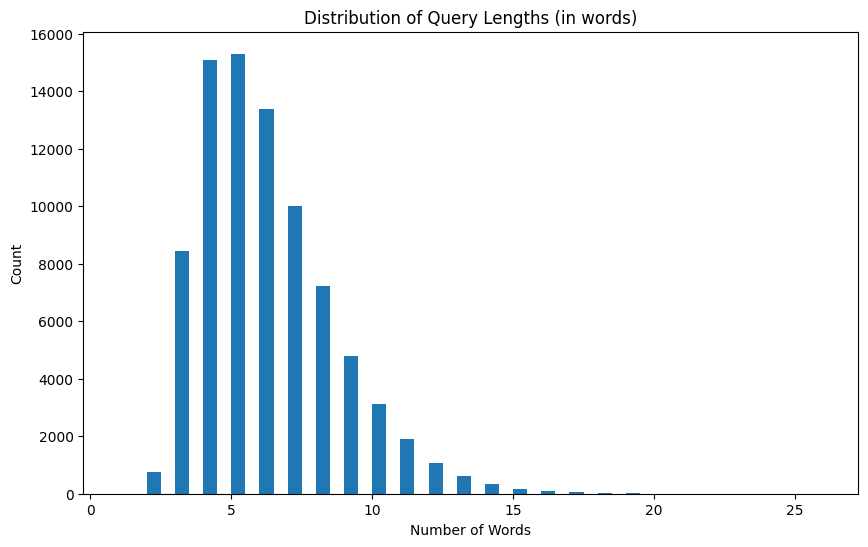

TypeError: string indices must be integers, not 'str'

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Plot distribution of query lengths
query_lengths = [len(example['query'].split()) for example in ds['train']]
plt.figure(figsize=(10, 6))
plt.hist(query_lengths, bins=50)
plt.title('Distribution of Query Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# Plot distribution of passage lengths
passage_lengths = []
for example in ds['train'][:1000]:  # Sample for faster processing
    for passage in example['passages']['passage_text']:
        passage_lengths.append(len(passage.split()))

plt.figure(figsize=(10, 6))
plt.hist(passage_lengths, bins=50)
plt.title('Distribution of Passage Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

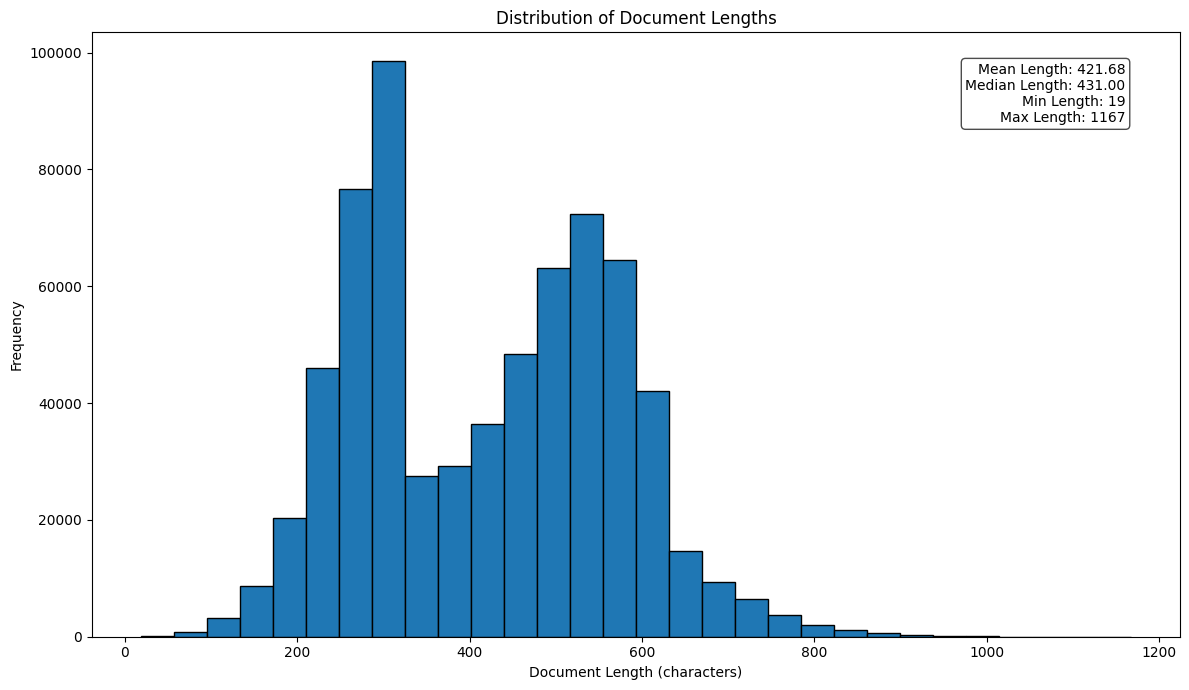

Document Length Statistics:
Total number of documents: 676193
Mean length: 421.68
Median length: 431.00
Minimum length: 19
Maximum length: 1167
Standard deviation: 147.38


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def get_document_lengths(dataset):
    lengths = []
    for example in dataset:
        lengths.extend(len(passage) for passage in example['passages']['passage_text'])
    return lengths

# Assuming ds is your dataset
document_lengths = get_document_lengths(ds['train'])

plt.figure(figsize=(12, 7))
plt.hist(document_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length (characters)')
plt.ylabel('Frequency')

plt.text(0.95, 0.95, 
         f'Mean Length: {np.mean(document_lengths):.2f}\n'
         f'Median Length: {np.median(document_lengths):.2f}\n'
         f'Min Length: {np.min(document_lengths)}\n'
         f'Max Length: {np.max(document_lengths)}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print("Document Length Statistics:")
print(f"Total number of documents: {len(document_lengths)}")
print(f"Mean length: {np.mean(document_lengths):.2f}")
print(f"Median length: {np.median(document_lengths):.2f}")
print(f"Minimum length: {np.min(document_lengths)}")
print(f"Maximum length: {np.max(document_lengths)}")
print(f"Standard deviation: {np.std(document_lengths):.2f}")

In [38]:
# Simple script to inspect model
import torch
import os

# Find the model file
artifact_dir = "./downloaded_model"
model_files = [f for f in os.listdir(artifact_dir) if f.endswith('.pth')]
model_path = os.path.join(artifact_dir, model_files[0])

# Load and inspect
model_data = torch.load(model_path, map_location=torch.device('cpu'))
print("Model type:", type(model_data))

# Recursively print structure
def print_structure(obj, indent=0):
    if isinstance(obj, dict):
        print(" " * indent + "{")
        for k, v in obj.items():
            print(" " * (indent + 2) + f"{k}: ", end="")
            if isinstance(v, (dict, list)) or (hasattr(v, "shape") and hasattr(v, "dtype")):
                print()
                print_structure(v, indent + 4)
            else:
                print(type(v))
        print(" " * indent + "}")
    elif isinstance(obj, list):
        print(" " * indent + "[")
        for item in obj[:3]:  # Print just first 3 for brevity
            print_structure(item, indent + 2)
        if len(obj) > 3:
            print(" " * (indent + 2) + "...")
        print(" " * indent + "]")
    elif hasattr(obj, "shape") and hasattr(obj, "dtype"):  # Tensor-like
        print(" " * indent + f"Tensor: shape={obj.shape}, dtype={obj.dtype}")
    else:
        print(" " * indent + str(type(obj)))

print_structure(model_data)

Model type: <class 'collections.OrderedDict'>
{
  emb.weight: 
    Tensor: shape=torch.Size([63642, 128]), dtype=torch.float32
  ffw.weight: 
    Tensor: shape=torch.Size([63642, 128]), dtype=torch.float32
}
